In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [3]:
plt.style.use('seaborn-dark')

In [4]:
walls = [
    (np.array([ 72, -72]), np.array([ 72,  72])), # warehouse
    (np.array([ 72,  72]), np.array([-72,  72])), # blue
    (np.array([-72,  72]), np.array([-72, -72])), # carousel
    (np.array([-72, -72]), np.array([ 72, -72])), # red
]

def setup_field(ax):
    ax.grid(True)
    # ax.set_xlabel('x')
    # ax.set_ylabel('y')
    ax.set_xticks(np.linspace(-72, 72, num=7))
    ax.set_yticks(np.linspace(-72, 72, num=7))
    ax.set_xlim([-72, 72])
    ax.set_ylim([-72, 72])
    ax.set_anchor('C')

<IPython.core.display.Javascript object>


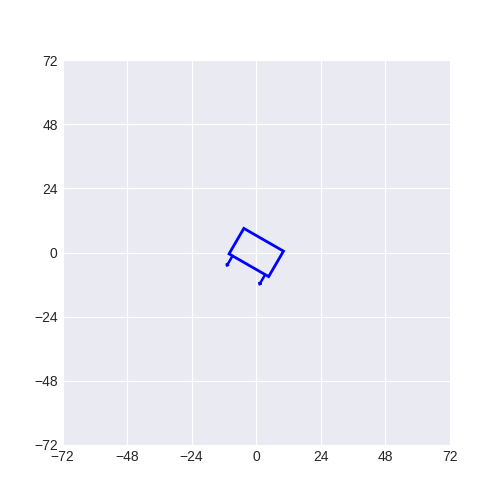

In [5]:
bot = np.array([12.0, 18.0])

bxx, byy = np.mgrid[-bot[0]/2.0:bot[0]/2.0:2j, -bot[1]/2.0:bot[1]/2.0:2j]
bot_corners = np.vstack([bxx.ravel(), byy.ravel()]).T

sensors = [
    np.array([-6, 7, np.pi]),
    np.array([-6, -7, np.pi]),
#     np.array([-4, 9, np.pi/2]),
#     np.array([-4, -9, -np.pi/2]),
]
sensor_sigma = 2
sensor_distr = scipy.stats.multivariate_normal(0, sensor_sigma**2, 6133)

def patch_bot(ax, pose):
    lw = 2
    dims = bot - np.array([lw/2, lw/2])
    x, y, th = pose
    vec = np.array([x, y])
    c, s = np.cos(th), np.sin(th)
    R = np.array([[c, -s], [s, c]])
    half_diag = dims / 2
    anchor = vec - R @ half_diag
    
    rect = mpatches.Rectangle(anchor, *dims, angle=np.degrees(th), color='blue', fill=False, lw=lw)
    ax.add_patch(rect)
    
    for s in sensors:
        sx, sy, sth = s
        svec = vec + R @ np.array([sx, sy])
        sc, ss = np.cos(th + sth), np.sin(th + sth)
        sdvec = np.array([sc, ss]) * 4
        arrow = mpatches.Arrow(*svec, *sdvec, width=2, color='blue')
        ax.add_patch(arrow)
    
fig, ax = plt.subplots(1, figsize=(5, 5))
setup_field(ax)
patch_bot(ax, np.array([0, 0, np.pi/3]))

In [6]:
# from https://web.archive.org/web/20111108065352/https://www.cs.mun.ca/~rod/2500/notes/numpy-arrays/numpy-arrays.html

#
# line segment intersection using vectors
# see Computer Graphics by F.S. Hill
#
def perp( a ) :
    b = np.empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b

# line segment a given by endpoints a1, a2
# line segment b given by endpoints b1, b2
# return 
def seg_intersect(a1,a2, b1,b2) :
    da = a2-a1
    db = b2-b1
    dp = a1-b1
    dap = perp(da)
    denom = np.dot( dap, db)
    num = np.dot( dap, dp )
    if denom == 0: return None
    return (num / denom)*db + b1

def my_intersect(a1, a2, b1, b2):
    da = a2-a1
    db = b2-b1
    dp = a1-b1
    

In [7]:
def real_dist(pose):
    x, y, th = pose
#     print(x, y, th)
    vec = np.array([x, y])
    c, s = np.cos(th), np.sin(th)
    R = np.array([[c, -s], [s, c]])
    m = np.empty((len(sensors), 2), dtype=np.float64)
    for i, s in enumerate(sensors):
        sx, sy, sth = s
        svec = vec + R @ np.array([sx, sy])
        if abs(svec[0]) > 72.0 or abs(svec[1]) > 72.0:
            m[i] = np.array([5000, 0.1])
            continue
        sc, ss = np.cos(th + sth), np.sin(th + sth)
        sdvec = np.array([sc, ss])
        endvec = svec + sdvec
        dists = np.array([])
        for w in walls:
            p = seg_intersect(sdvec, endvec, *w)
#             print(p)
            if type(p) is not np.ndarray: continue
            d = (p - svec)[0] / sdvec[0]
#             print(d)
            if d < 0: continue
            dists = np.append(dists, d)
        m[i] = np.array([5000, 0.1]) if len(dists) == 0 else np.array([min(dists), sensor_sigma])
#     print(m)
    return m
def like(pdfs, meas):
    P = 1
    for p, m in zip(pdfs, meas):
#         print(p, m)
        P *= scipy.stats.norm.pdf(m, p[0], p[1])
    return P

In [8]:
%time
step = 2.0
angle = 0.0
angle_count = 16
xx, yy, tt = np.mgrid[-72.0:73.0:step, -72.0:73.0:step, 0:2*np.pi:angle_count*1j]
# xx, yy, tt = np.mgrid[-72.0:73.0:step, -72.0:73.0:step, angle:angle+1.0]
particles = np.vstack([xx.ravel(), yy.ravel(), tt.ravel()]).T
print(len(particles))


measurements = np.array([10.0, 12.0])
hypothetical_pdfs = np.array(list(map(real_dist, particles)))
likelihood = np.array(list(map(lambda p: like(p, measurements), hypothetical_pdfs)))


CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 4.53 µs
85264


<IPython.core.display.Javascript object>


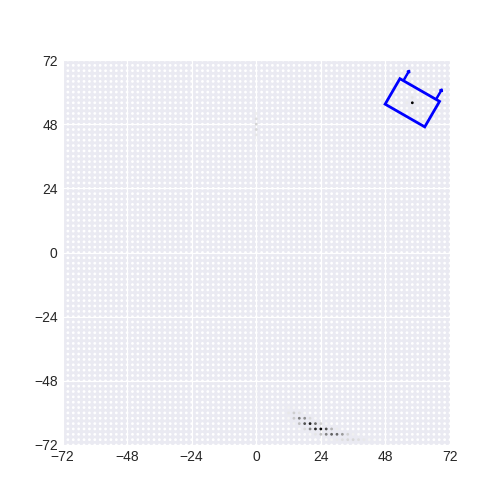

10.666666666666666


In [14]:
fig, ax = plt.subplots(1, figsize=(5, 5))

best_index = np.argmax(likelihood)
best_particle = particles[best_index]
best_heading = best_particle[2]
best_n = best_heading / (2 * np.pi / angle_count)
print(best_n)
setup_field(ax)

indices = []
for i, p in enumerate(particles):
    if p[2] == best_heading:
        indices.append(i)

q = ax.scatter(xx[:, :, int(best_n)], yy[:, :, int(best_n)], c=np.take(likelihood, np.array(indices)), s=1)

patch_bot(ax, best_particle)
# q = ax.scatter(xx[:, :, 0], yy[:, :, 0], c=hypothetical_pdfs[:, 0, 0], s=1, cmap='viridis')
# fig.colorbar(True)


<IPython.core.display.Javascript object>


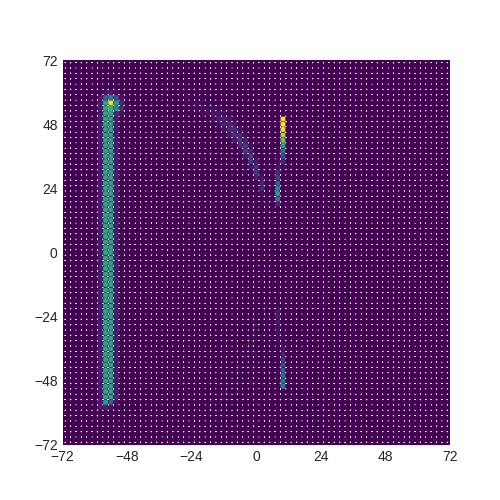

In [15]:
fig, ax = plt.subplots(1, figsize=(5, 5))
setup_field(ax)
q = ax.scatter(xx, yy, c=likelihood, s=8, cmap='viridis')

<IPython.core.display.Javascript object>


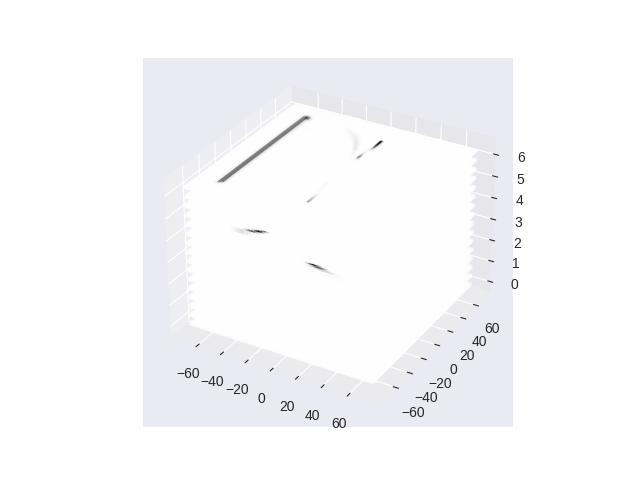

In [16]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
q = ax.scatter(xx, yy, tt, c=likelihood, s=6)

In [12]:
print(hypothetical_pdfs.shape)

(85264, 2, 2)


In [13]:
r = 0
print(particles[r:r+10])
print(hypothetical_pdfs[r:r+10, 0, 0])
print(likelihood[r:r+10])

[[-72.         -72.           0.        ]
 [-72.         -72.           0.41887902]
 [-72.         -72.           0.83775804]
 [-72.         -72.           1.25663706]
 [-72.         -72.           1.67551608]
 [-72.         -72.           2.0943951 ]
 [-72.         -72.           2.51327412]
 [-72.         -72.           2.93215314]
 [-72.         -72.           3.35103216]
 [-72.         -72.           3.76991118]]
[5000. 5000. 5000. 5000. 5000. 5000. 5000. 5000. 5000. 5000.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
